# 05 Register phase volumes to noncon (Round 2: Using Dipy Package)

### Goal: Finish registration for cases that ANTs framework didn't work well for

For looped/automated see 05-registration.py

In [44]:
import numpy as np
from dipy.viz import regtools
from dipy.align import affine_registration
from dipy.align.imaffine import AffineMap
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import EMMetric, CCMetric
import nibabel as nib
import os
import shutil
from utils import view_registration, view_registration_with_mask, find_midz, crop_nifti_z, view_reg_path, view_reg_mask_path, get_mask_fname, fix_reg_nslice

## Registration QC and Adjustment

In [ ]:
pid = 'LI7VGJbXvc'  # CHANGE THIS! 
base_dir ='/data/larson2/RCC_dl/data2022/'
print('--------------------------------'+pid+'--------------------------------')

--------------------------------LI7VGJbXvc--------------------------------


In [ ]:
shutil.copyfile(os.path.join(base_dir, pid, 'noncon.nii.gz'), os.path.join(base_dir, pid, 'noncon_cropped.nii.gz'))

'/data/larson2/RCC_dl/data2022/LI7VGJbXvc/noncon_cropped.nii.gz'

In [ ]:
shutil.copyfile(os.path.join(base_dir, pid, 'BB_R_noncon_markers_1.nii.gz'), os.path.join(base_dir, pid, 'BB_R_noncon_markers_1_cropped.nii.gz'))

'/data/larson2/RCC_dl/data2022/BO1IyjmA7c/BB_R_noncon_markers_1_cropped.nii.gz'

In [ ]:
shutil.copyfile(os.path.join(base_dir, pid, 'BB_L_noncon_markers_1.nii.gz'), os.path.join(base_dir, pid, 'BB_L_noncon_markers_1_cropped.nii.gz'))

'/data/larson2/RCC_dl/data2022/LI7VGJbXvc/BB_L_noncon_markers_1_cropped.nii.gz'

In [ ]:
# First, visualize current registration

# determine which phases we have for the pid
phases = {'arterial', 'delay', 'portven'}
phases = [p for p in phases if os.path.isfile(os.path.join(base_dir, pid, (p+'_reg.nii.gz')))] #make sure registered phase images exist in folder
print('phases:', phases)

# get path for noncon image and its mask
noncon_mask_fname = get_mask_fname(os.path.join(base_dir, pid), "noncon", suffix="_cropped")
noncon = os.path.join(base_dir, pid, 'noncon_cropped.nii.gz')

if os.path.exists(os.path.join(base_dir,pid,noncon_mask_fname)):
    noncon_mask = os.path.join(base_dir, pid, noncon_mask_fname)    
    nc_mask_img = nib.load(noncon_mask).get_fdata()
    # find center, min and max of tumor in z
    minz, midz, maxz = find_midz(nc_mask_img)
    #print(minz, midz, maxz)

phase_imgs = []
phase_masks = []
for phase in phases:
    print('--------------------'+phase+'--------------------')

    # for each phase get path for image and mask
    phase_mask_fname = get_mask_fname(os.path.join(base_dir, pid), phase, suffix="_reg")
    phase = os.path.join(base_dir, pid, (phase +'_reg.nii.gz'))
    phase_imgs.append(phase)

    if os.path.exists(os.path.join(base_dir,pid,phase_mask_fname)):
        phase_mask = os.path.join(base_dir, pid, phase_mask_fname)
        phase_masks.append(phase_mask) 
        if not os.path.exists(os.path.join(base_dir,pid,noncon_mask_fname)):
            minz, midz, maxz =find_midz(nib.load(phase_mask).get_fdata())

    # visualize 5 axial slices in the center, bottom and top of tumor with and without mask overlaid
    print('-----Center of Tumor-----')
    view_reg_path(noncon, phase, [midz, midz])
    print(os.path.exists(os.path.join(base_dir,pid,phase_mask_fname)))
    print(os.path.exists(os.path.join(base_dir,pid,noncon_mask_fname)))
    if os.path.exists(os.path.join(base_dir,pid,phase_mask_fname)) and os.path.exists(os.path.join(base_dir,pid,noncon_mask_fname)):
        view_reg_mask_path(noncon, phase, noncon_mask, phase_mask, [midz-2, midz-2])

    print('-----Bottom of Tumor-----')
    view_reg_path(noncon, phase, [maxz, maxz])
    if os.path.exists(os.path.join(base_dir,pid,phase_mask_fname)) and os.path.exists(os.path.join(base_dir,pid,noncon_mask_fname)):
        view_reg_mask_path(noncon, phase, noncon_mask, phase_mask, [maxz, maxz])
        
    print('-----Top of Tumor-----')
    view_reg_path(noncon, phase, [minz, minz])
    if os.path.exists(os.path.join(base_dir,pid,phase_mask_fname)) and os.path.exists(os.path.join(base_dir,pid,noncon_mask_fname)):
        view_reg_mask_path(noncon, phase, noncon_mask, phase_mask, [minz, minz])

In [ ]:
# adjustment in slice (z) direction
# Using fix_reg_nslice: 
# "down" = crop the beginning of the phase slices, end of noncon i.e. noncon is cropped [0, max-n] and phase is cropped [n, max]
# "up" = crop the beginning of the noncon slices, end of phase i.e. noncon is cropped [n, max] and phase is cropped [0, max-n]
# then adjust other phases/masks based on this so they still line up

n=1
#zmax = 58
save_path = phase_imgs[0]
#save_path_mask = phase_masks[0] #check these numbers if masks missing
#save_path2 = phase_imgs[1]
#save_path_mask2 = phase_masks[0]
#save_path3 = phase_imgs[2]
#save_path_mask3 = phase_masks[0]

#adjust if needed
fix_reg_nslice(save_path, noncon, 'down', n) #up = move phase to right, down=move phase to left  (NOTE: if up will crop noncon and have to redo reg for other phases)
#if os.path.exists(os.path.join(base_dir,pid,noncon_mask_fname)):
#    fix_reg_nslice(save_path_mask2, noncon_mask, 'down', n)
#else:
#    crop_nifti_z(save_path_mask, n, 70) 
#    crop_nifti_z(save_path_mask, 0, 161-n) 
#fix_reg_nslice(save_path_mask2, noncon_mask, 'up', n)
crop_nifti_z(noncon_mask, 0, 102-n)

#crop_nifti_z(save_path, n, 57) 
#crop_nifti_z(save_path_mask, n, 228) 
#crop_nifti_z(save_path2, n, 326) #if using "up" crop other phases like noncon to keep registration the same
#crop_nifti_z(save_path_mask2, n, 51) #if using "up" crop other phases like noncon to keep registration the same
#crop_nifti_z(save_path3, n, 112) #if using "up" crop other phases like noncon to keep registration the same
#crop_nifti_z(save_path_mask3, n, 112) #if using "up" crop other phases like noncon to keep registration the same
#crop_nifti_z(save_path, 0, 78-n) 
#crop_nifti_z(save_path_mask, 0, 78-n) 
#crop_nifti_z(save_path2, 0, 785-n) 
#crop_nifti_z(save_path_mask2, 0, 29-n) 
#crop_nifti_z(save_path3, 1, 120-1) 
#crop_nifti_z(save_path_mask3, 0, 53-n) 

# visualize registration
view_reg_path(noncon, save_path, [midz-n, midz-n])
view_reg_path(noncon, save_path, [maxz-n, maxz-n])
view_reg_path(noncon, save_path, [minz-n, minz-n])

#view_reg_mask_path(noncon, save_path, noncon_mask, save_path_mask, [midz-n, midz-n])
#view_reg_mask_path(noncon, save_path, noncon_mask, save_path_mask, [maxz-n, maxz-n])
#view_reg_mask_path(noncon, save_path, noncon_mask, save_path_mask, [minz-n, minz-n])

#view_reg_path(noncon, save_path2, [midz-n, midz-n])
#view_reg_path(noncon, save_path2, [maxz-n, maxz-n])
#view_reg_path(noncon, save_path2, [minz-n, minz-n])

#view_reg_mask_path(noncon, save_path2, noncon_mask, save_path_mask2, [midz-n, midz-n])
#view_reg_mask_path(noncon, save_path2, noncon_mask, save_path_mask2, [maxz-n, maxz-n])
#view_reg_mask_path(noncon, save_path2, noncon_mask, save_path_mask2, [minz-n, minz-n])

#view_reg_path(noncon, save_path3, [midz-n, midz-n])
#view_reg_path(noncon, save_path3, [maxz-n, maxz-n])
#view_reg_path(noncon, save_path3, [minz-n, minz-n])

#view_reg_mask_path(noncon, save_path3, noncon_mask, save_path_mask3, [midz-n, midz-n])
#view_reg_mask_path(noncon, save_path3, noncon_mask, save_path_mask3, [maxz-n, maxz-n])
#view_reg_mask_path(noncon, save_path3, noncon_mask, save_path_mask3, [minz-n, minz-n])



## Single Registration Example

For looped/automated see 05-registration.py

In [ ]:
data_path = '/data/larson2/RCC_dl/data2022/'
pid = '6vAXtkl1b4'   #'cekvauupUQ' - prone/supine
static_fname = 'noncon.nii.gz'
moving_fname = 'delay.nii.gz'
static_mask_fname = 'right_kidney_noncon.nii.gz'
moving_mask_fname = 'right_kidney_delay.nii.gz'

static = nib.load(os.path.join(data_path,pid,static_fname))
moving = nib.load(os.path.join(data_path,pid,moving_fname))
static_mask = nib.load(os.path.join(data_path,pid,static_mask_fname))
moving_mask = nib.load(os.path.join(data_path,pid,moving_mask_fname))

static_img = static.get_fdata()
moving_img = moving.get_fdata()
static_mask_img = static_mask.get_fdata()
moving_mask_img = moving_mask.get_fdata()

minz, midz, maxz =find_midz(static_mask_img)

save_path = '/working/larson2/ssahin/rcc_dl/QC'

if not os.path.exists(os.path.join(save_path,pid)):
    os.makedirs(os.path.join(save_path,pid))

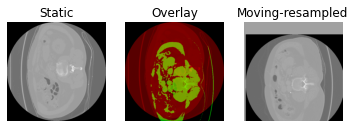

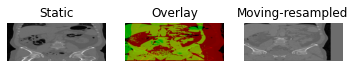

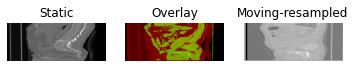

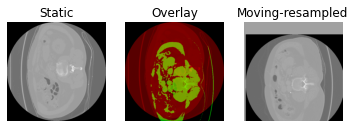

In [ ]:
#Plot Initial (before registration)

identity = np.eye(4)
affine_map = AffineMap(identity,
                       static_img.shape, static.affine,
                       moving_img.shape, moving.affine)
resampled = affine_map.transform(moving_img)

regtools.overlay_slices(static_img, resampled, None, 0,
                        "Static", "Moving-resampled", os.path.join(save_path,pid,'initial_0.png'))
regtools.overlay_slices(static_img, resampled, None, 1,
                        "Static", "Moving-resampled", os.path.join(save_path,pid,'initial_1.png'))
regtools.overlay_slices(static_img, resampled, None, 2,
                        "Static", "Moving-resampled", os.path.join(save_path,pid,'initial_2.png'))

In [ ]:
# AFFINE REGISTRATION

pipeline = ["center_of_mass", "translation", "rigid", "affine"]
level_iters = [10000, 1000, 100] #number of iterations at three diff resolutions 10000 at the coarsest, 100 at finest
sigmas = [3.0, 1.0, 0.0] #sigma values for gaussian pyramid
factors = [4, 2, 1] #controls res of registration i.e. coarsest reg here would done at (nx//4, ny//4, nz//4) where (nx,ny,nz) is OG

xformed_img, reg_affine = affine_registration(
    moving_img,
    static_img,
    moving_affine=moving.affine,
    static_affine=static.affine,
    nbins=32,
    metric='MI',
    pipeline=pipeline,
    level_iters=level_iters,
    sigmas=sigmas,
    factors=factors,
    static_mask = static_mask_img,
    moving_mask = moving_mask_img)

# also register mask with same transform
affine_map = AffineMap(reg_affine,
                       static_mask_img.shape, static_mask.affine,
                       moving_mask_img.shape, moving_mask.affine)
moving_mask_img_xformed = affine_map.transform(moving_mask_img)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [ ]:
print(reg_affine)

In [ ]:
# NONLINEAR (SyN) REGISTRATION
#new_affine = moving.affine.dot(reg_affine)
#new_affine_mask = moving_mask.affine.dot(reg_affine)

#metric = CCMetric(3) #contrasts are different bw phases so not sure cross correlation will work best
metric = EMMetric(3)
level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)
mapping = sdr.optimize(static_img, moving_img, static.affine, moving.affine, reg_affine)
xformed_img = mapping.transform(moving_img)
moving_mask_img_xformed = mapping.transform(moving_mask_img) # also register mask with same transform

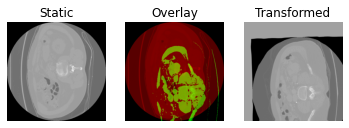

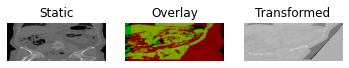

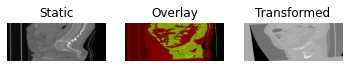

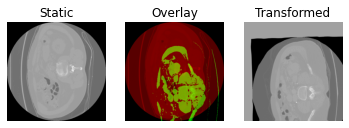

In [ ]:
# QC pt 1

regtools.overlay_slices(static_img, xformed_img, None, 0,
                        "Static", "Transformed", os.path.join(save_path,pid,'xformed_affine_0.png'))
regtools.overlay_slices(static_img, xformed_img, None, 1,
                        "Static", "Transformed", os.path.join(save_path,pid,'xformed_affine_1.png'))
regtools.overlay_slices(static_img, xformed_img, None, 2,
                        "Static", "Transformed", os.path.join(save_path,pid,'xformed_affine_2.png'))


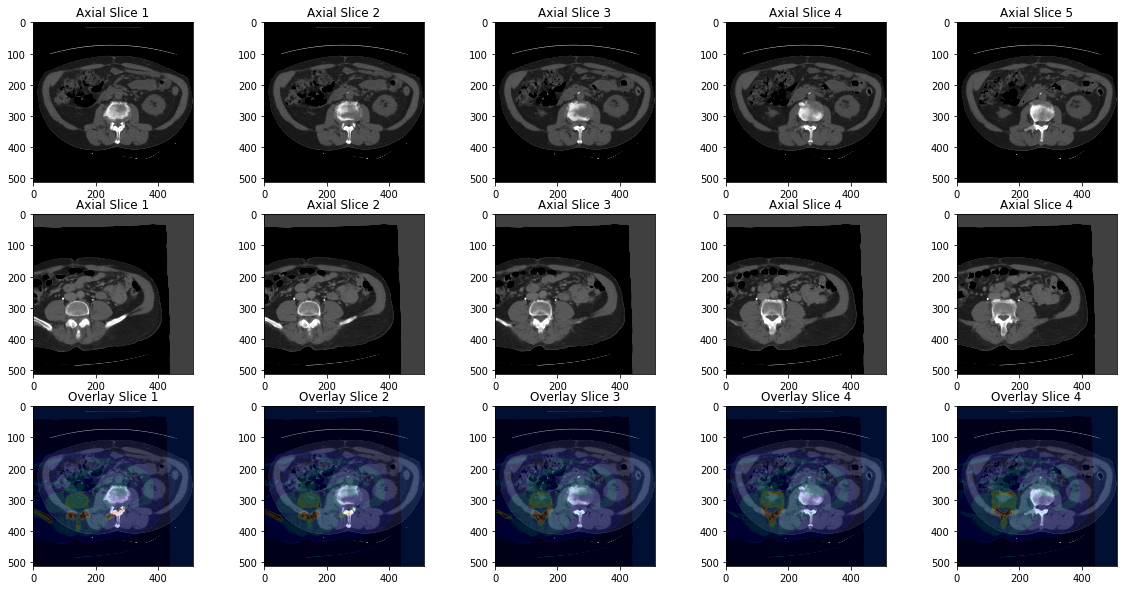

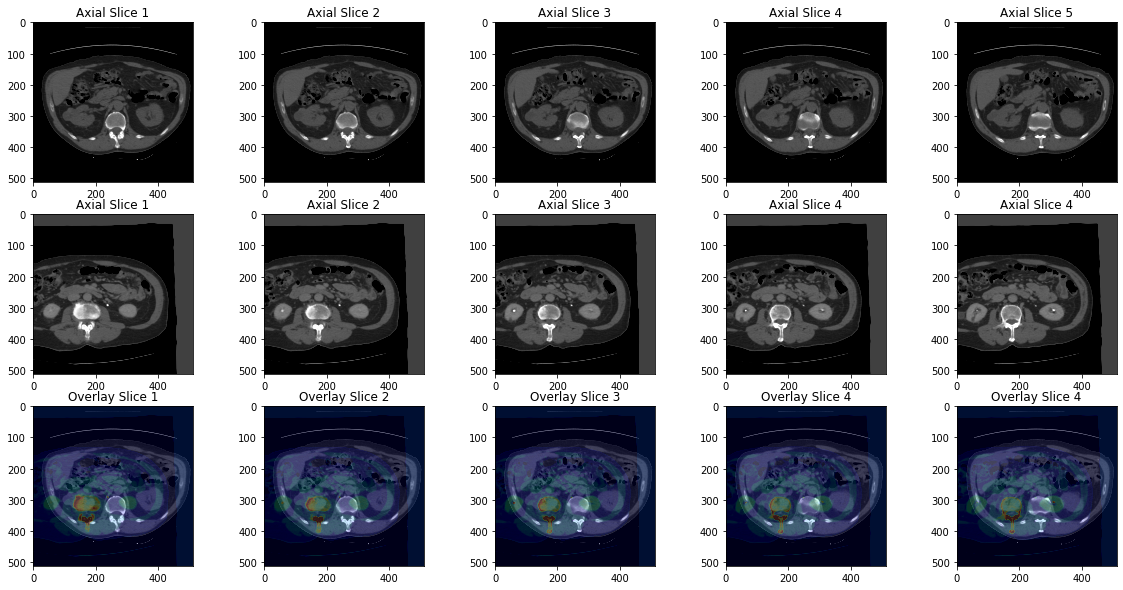

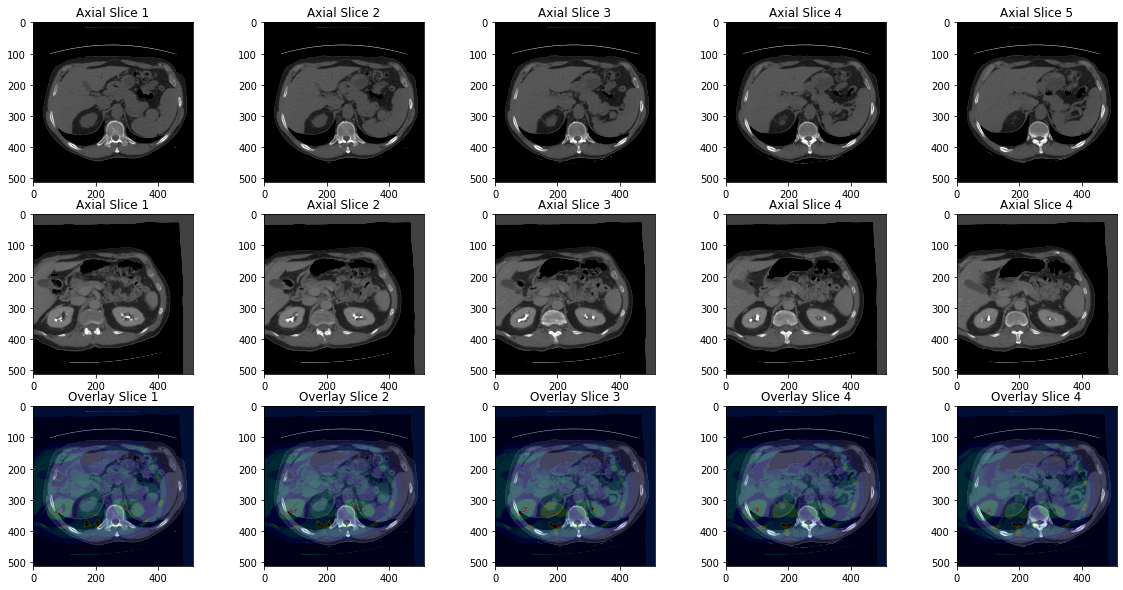

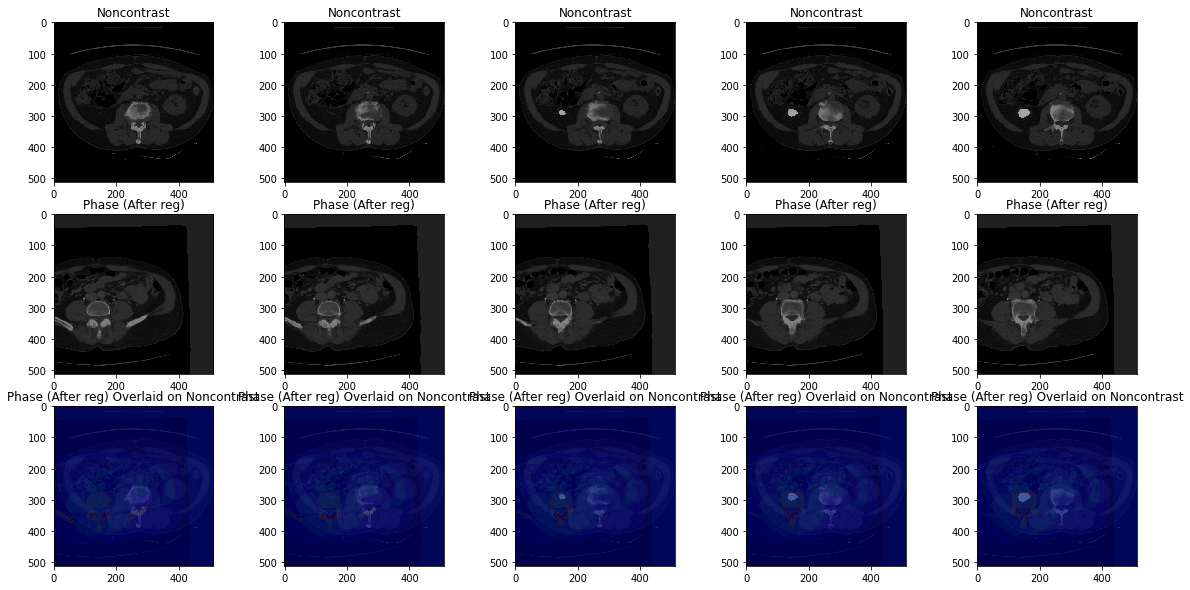

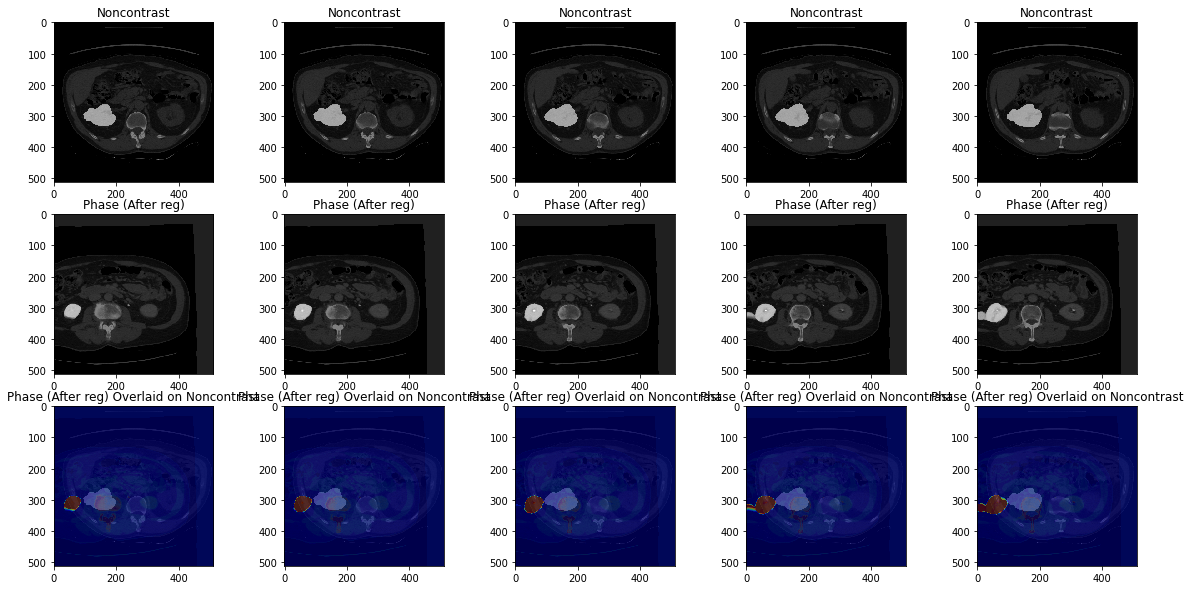

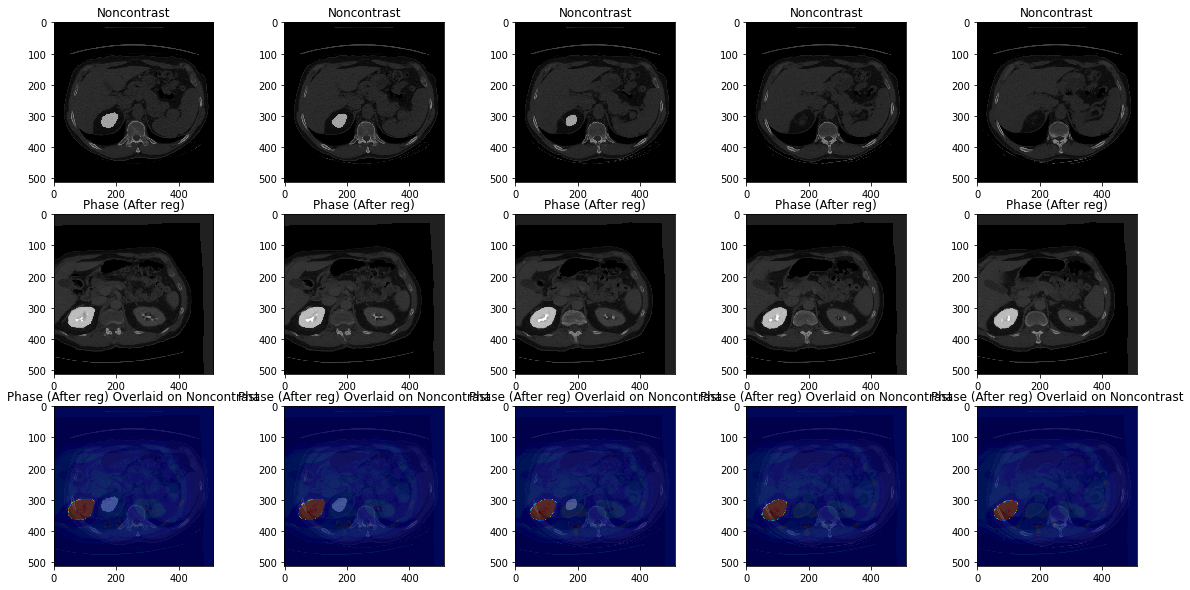

In [ ]:
# QC pt 2

view_registration(static_img, xformed_img, [minz, minz], savepath=os.path.join(save_path,pid,'QC_minz.png'))
view_registration(static_img, xformed_img, [midz, midz], savepath=os.path.join(save_path,pid,'QC_midz.png'))
view_registration(static_img, xformed_img, [maxz, maxz], savepath=os.path.join(save_path,pid,'QC_maxz.png'))
view_registration_with_mask(static_img, xformed_img, static_mask_img, moving_mask_img_xformed, [minz, minz], savepath=os.path.join(save_path,pid,'QC_minz_wmask.png'))
view_registration_with_mask(static_img, xformed_img, static_mask_img, moving_mask_img_xformed,  [midz, midz], savepath=os.path.join(save_path,pid,'QC_midz_wmask.png'))
view_registration_with_mask(static_img, xformed_img, static_mask_img, moving_mask_img_xformed,  [maxz, maxz], savepath=os.path.join(save_path,pid,'QC_maxz_wmask.png'))

In [ ]:
print(static_img.shape)
print(moving_img.shape)
print(xformed_img.shape)

print(static_mask_img.shape)
print(moving_mask_img.shape)
print(moving_mask_img_xformed.shape)

(512, 512, 47)
(512, 512, 110)
(512, 512, 47)
(512, 512, 47)
(512, 512, 110)
(512, 512, 47)


In [ ]:
# save finalized images as niftis
new_affine = moving.affine.dot(reg_affine)
new_affine_mask = moving_mask.affine.dot(reg_affine)
xformed = nib.Nifti1Image(xformed_img, affine=new_affine, header=moving.header) 
xformed_mask = nib.Nifti1Image(moving_mask_img_xformed, affine=new_affine_mask, header=moving_mask.header) 

xformed_path = os.path.join(save_path,pid,'xformed.nii')
xformed_mask_path = os.path.join(save_path,pid,'xformed_mask.nii')

nib.save(xformed, xformed_path)
nib.save(xformed_mask, xformed_mask_path)

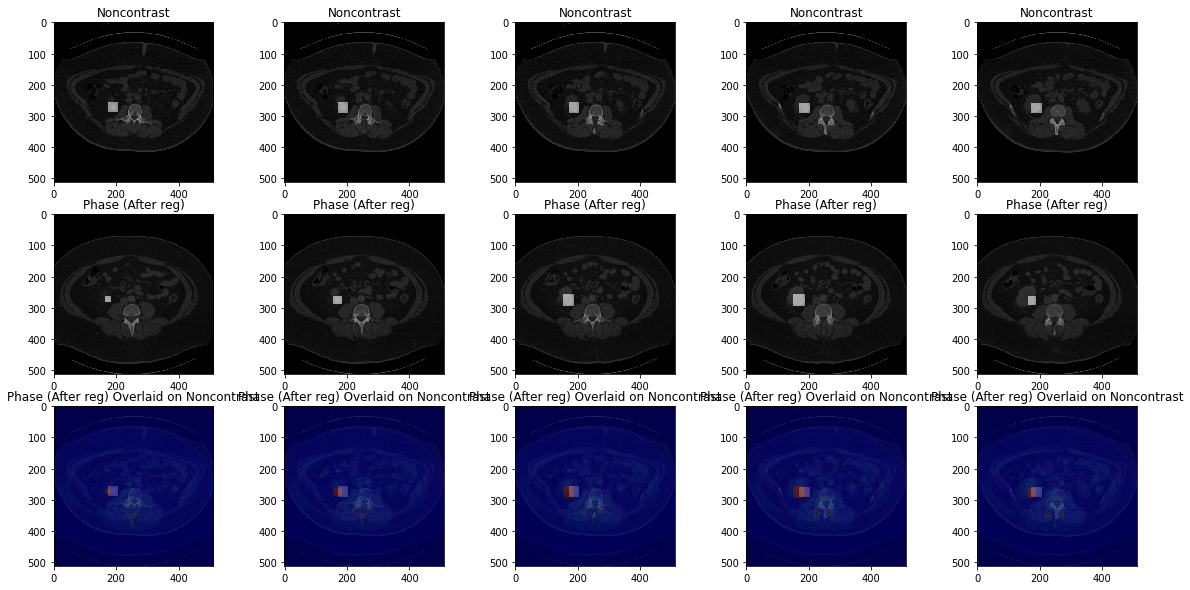

In [ ]:
view_registration_with_mask(static_img, moving_img, static_mask_img, moving_mask_img,  [midz, midz], os.path.join(save_path,pid,'QC_midz_wmask.png'))

In [ ]:
print(moving.affine)
print(reg_affine)

In [ ]:


new_affine = moving.affine.dot(reg_affine)
new_affine_mask = moving_mask.affine.dot(reg_affine)

pipeline = ["center_of_mass", "translation", "rigid", "affine"]
level_iters = [100000, 10000, 1000, 100] #number of iterations at three diff resolutions 10000 at the coarsest, 100 at finest
sigmas = [5.0, 3.0, 1.0, 0.0] #sigma values for gaussian pyramid
factors = [8, 4, 2, 1] #controls res of registration i.e. coarsest reg here would done at (nx//4, ny//4, nz//4) where (nx,ny,nz) is OG

xformed_img, reg_affine = affine_registration(
    xformed_img,
    static_img,
    moving_affine=new_affine,
    static_affine=static.affine,
    nbins=32,
    metric='MI',
    pipeline=pipeline,
    level_iters=level_iters,
    sigmas=sigmas,
    factors=factors)

# also register mask with same transform
affine_map = AffineMap(reg_affine,
                       static_mask_img.shape, static_mask.affine,
                       moving_mask_img_xformed.shape, new_affine_mask)
moving_mask_img_xformed = affine_map.transform(moving_mask_img_xformed)

Optimizing level 3 [max iter: 100000]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 3 [max iter: 100000]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 3 [max iter: 100000]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
